<a href="https://colab.research.google.com/github/D4us-M4chanicus/Handwritten-letter-recognition/blob/main/Using_a_fully_connected_neural_network_to_recognize_handwritten_letters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Загрузка и предобработка данных**

In [ ]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras import models
from keras import layers
from keras import utils
from keras.utils import to_categorical

In [ ]:
# Загрузка датасета и преобразование в датафрэйм: "I_E_h_l" - "Images of English handwritten letters"
url = "https://storage.yandexcloud.net/academy.ai/A_Z_Handwritten_Data.csv"
I_E_h_l = pd.read_csv(url)

# Вывод первых 5 строк
print(I_E_h_l.head())

   0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.639  0.640  0.641  \
0  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.642  0.643  0.644  0.645  0.646  0.647  0.648  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]


In [ ]:
# Получение краткой информации и проверка на дубли
print(I_E_h_l.info())
print(I_E_h_l.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: int64(785)
memory usage: 2.2 GB
None
171355


In [ ]:
# Удаление дублей и сброс индексов
I_E_h_l.drop_duplicates(inplace=True)
I_E_h_l.reset_index(drop=True, inplace=True)

# Проверка информации
print(I_E_h_l.info())
print(I_E_h_l.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201095 entries, 0 to 201094
Columns: 785 entries, 0 to 0.648
dtypes: int64(785)
memory usage: 1.2 GB
None
0


In [ ]:
# Проверка соотношения меток в наборе
N_e_e_l = I_E_h_l['0'].value_counts()
print(N_e_e_l)

0
14    29306
18    24622
20    14921
2     12170
19    11698
12    10373
15    10087
13     9909
0      7680
11     6226
17     6170
4      6039
24     5833
22     5804
3      5430
1      4804
9      4593
7      3974
23     3557
25     3432
16     3281
6      3206
10     3156
21     2616
5      1147
8      1061
Name: count, dtype: int64


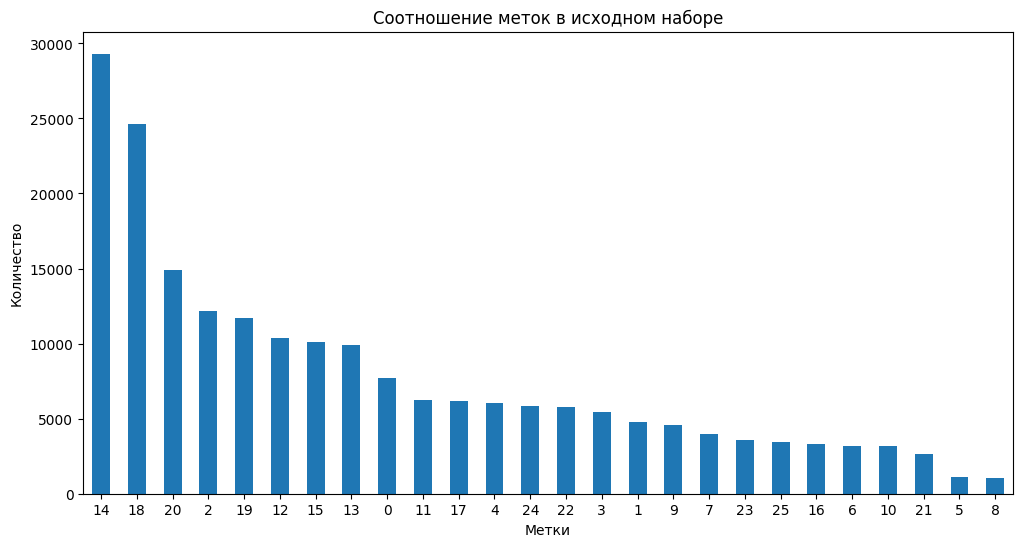

In [ ]:
%matplotlib inline

# Построение столбчатой диаграммы
N_e_e_l.plot(kind='bar', figsize=(12, 6))
plt.title('Соотношение меток в исходном наборе')
plt.xlabel('Метки')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Функция для уменьшения количества примеров у наиболее представленных классов
def reduce_to_10000_per_label(df, label_column):
    # Группировка по меткам
    grouped = df.groupby(label_column)

    # Список для хранения отфильтрованных данных
    filtered_data = []

    # Проход по каждой группе
    for label, group in grouped:
        if len(group) > 10000:
            # Если в группе больше 10000 примеров, выбор случайных 10000
            group = group.sample(n=10000, random_state=42)
        # Если в группе 10000 или меньше примеров - без изменений
        # Добавление группы в список
        filtered_data.append(group)

    # Объединение всех групп обратно в один DataFrame
    reduced_df = pd.concat(filtered_data)

    return reduced_df

In [ ]:
# Уменьшение количества примеров до 10000 у наиболее представленных классов
r_I_E_h_l = reduce_to_10000_per_label(I_E_h_l, '0')

# Проверка
print(r_I_E_h_l['0'].value_counts())

0
12    10000
2     10000
20    10000
19    10000
18    10000
15    10000
14    10000
13     9909
0      7680
11     6226
17     6170
4      6039
24     5833
22     5804
3      5430
1      4804
9      4593
7      3974
23     3557
25     3432
16     3281
6      3206
10     3156
21     2616
5      1147
8      1061
Name: count, dtype: int64


In [ ]:
# Разделение датафрэйма на признаки X и метки y
X = r_I_E_h_l.iloc[:,1:785]
y = r_I_E_h_l.iloc[:,0]

In [ ]:
# Увеличение количества примеров у менее представленных классов
smote = SMOTE()
X_1, y_1 = smote.fit_resample(X, y)

# Проверка
print(y_1.value_counts())

0
0     10000
1     10000
24    10000
23    10000
22    10000
21    10000
20    10000
19    10000
18    10000
17    10000
16    10000
15    10000
14    10000
13    10000
12    10000
11    10000
10    10000
9     10000
8     10000
7     10000
6     10000
5     10000
4     10000
3     10000
2     10000
25    10000
Name: count, dtype: int64


In [ ]:
# Изменение типа данных и нормирмировние на максимальное значение в тензоре (приведение к диапазону [0, 1])
X_2 = X_1.astype('float32') / 255

In [ ]:
# Разделение на обучающий, валидационный и тестовый наборы
X_train, X_temp, y_train, y_temp = train_test_split(X_2, y_1, test_size=0.4, random_state=42, stratify=y_1, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42, stratify=y_temp, shuffle=True)

In [ ]:
# Проверка соотношения и количества
print(f"Обучающий набор:\n{(y_train.value_counts())}\nВсего: {len(y_train)}\n\n"
      f"Валидационный набор:\n{(y_val.value_counts())}\nВсего: {len(y_val)}\n\n"
      f"Тестовый набор:\n{(y_test.value_counts())}\nВсего: {len(y_test)}")

Обучающий набор:
0
2     6000
24    6000
0     6000
9     6000
13    6000
12    6000
20    6000
23    6000
16    6000
19    6000
22    6000
17    6000
14    6000
10    6000
7     6000
1     6000
21    6000
15    6000
18    6000
8     6000
11    6000
5     6000
6     6000
25    6000
4     6000
3     6000
Name: count, dtype: int64
Всего: 156000

Валидационный набор:
0
5     2400
23    2400
6     2400
1     2400
21    2400
13    2400
14    2400
11    2400
8     2400
2     2400
18    2400
15    2400
19    2400
9     2400
20    2400
10    2400
24    2400
22    2400
12    2400
25    2400
0     2400
16    2400
17    2400
4     2400
3     2400
7     2400
Name: count, dtype: int64
Всего: 62400

Тестовый набор:
0
20    1600
17    1600
4     1600
16    1600
13    1600
6     1600
5     1600
23    1600
10    1600
15    1600
0     1600
21    1600
11    1600
25    1600
2     1600
22    1600
12    1600
9     1600
14    1600
7     1600
24    1600
1     1600
19    1600
8     1600
18    1600
3     1600
N

In [ ]:
# Создание DataFrame из Series для визуализации
df = pd.DataFrame({
    'Обучающий набор': y_train.value_counts(),
    'Валидационный набор': y_val.value_counts(),
    'Тестовый набор': y_test.value_counts()
})

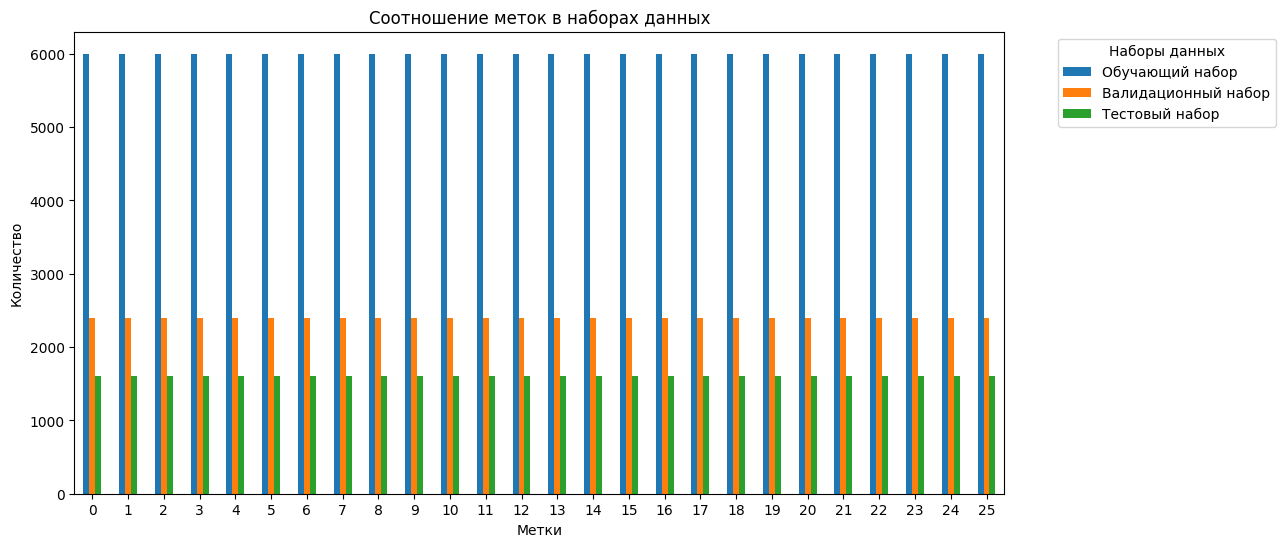

In [ ]:
%matplotlib inline

# Построение столбчатой диаграммы
df.plot(kind='bar', figsize=(12, 6))
plt.title('Соотношение меток в наборах данных')
plt.xlabel('Метки')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.legend(title='Наборы данных', bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
# Векторизация меток на 26 классов
y_train_2 = to_categorical(y_train, 26)
y_val_2 = to_categorical(y_val, 26)
y_test_2 = to_categorical(y_test, 26)

## **Конструирование и компиляция модели**

In [ ]:
# Конструирование модели
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(784,)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

# Компиляция
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


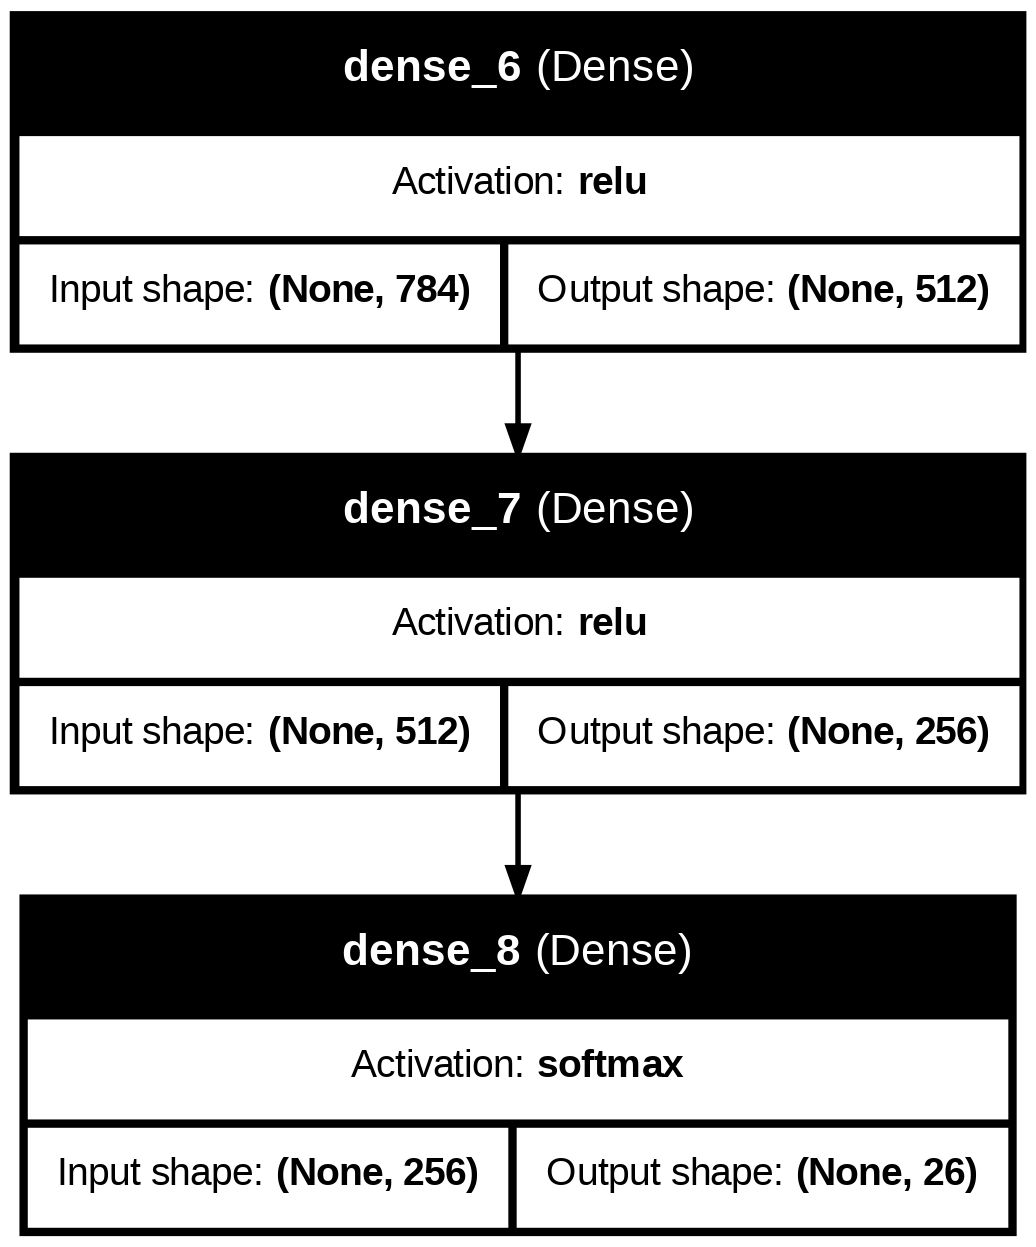

In [ ]:
# Построение графика модели
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

## **Обучение и оценка**

In [ ]:
# Сохранение истории процесса обучения
history = model.fit(X_train, y_train_2, validation_data=(X_val, y_val_2), epochs=5, batch_size=254)

Epoch 1/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.8070 - loss: 0.6914 - val_accuracy: 0.9425 - val_loss: 0.1945
Epoch 2/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9644 - loss: 0.1238 - val_accuracy: 0.9527 - val_loss: 0.1629
Epoch 3/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.9764 - loss: 0.0811 - val_accuracy: 0.9597 - val_loss: 0.1385
Epoch 4/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9837 - loss: 0.0542 - val_accuracy: 0.9778 - val_loss: 0.0781
Epoch 5/5
615/615 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9880 - loss: 0.0404 - val_accuracy: 0.9751 - val_loss: 0.0897


In [ ]:
# Проверка на тестовом наборе и вывод данных
test_loss, test_acc = model.evaluate(X_test, y_test_2)
print('Точность на тестовом наборе:', test_acc)
print('Потери на тестовом наборе:', test_loss)

1300/1300 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9772 - loss: 0.0899
Точность на тестовом наборе: 0.9761778712272644
Потери на тестовом наборе: 0.09444089233875275


## **Предсказание**

Введите индекс картинки (целое число от 0 до 41599): 5678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

Вектор результата на 26 выходных нейронах:
[[9.99999762e-01 6.86001522e-09 3.78363790e-12 5.37588745e-13
  1.37678575e-11 2.37471653e-10 7.31938329e-11 1.47050642e-07
  2.02938414e-16 7.90486129e-15 9.68256170e-11 5.36340009e-14
  2.76437384e-09 3.72983554e-11 4.77372895e-14 7.61367358e-10
  2.71556614e-11 4.73216026e-08 5.11689419e-14 8.32293623e-10
  1.19997057e-14 3.51555731e-15 3.43432456e-14 2.52350275e-14
  3.79467914e-13 6.62701005e-10]]

Распознана буква - A
Правильная буква - A



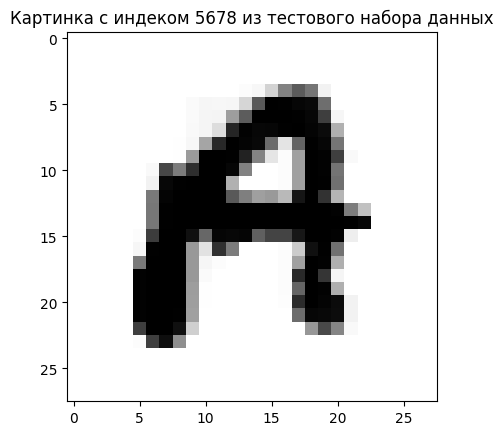

In [ ]:
# Выбор нужной картинки из тестовой выборки
n = int(input("Введите индекс картинки (целое число от 0 до 41599): "))
x = X_test.iloc[n]

# Массив из одного примера, так как нейронка принимает именно массивы примеров (батчи) для распознавания
m = np.expand_dims(x, axis=0)

# Предсказываем выбранную картинку
prediction = model.predict(m)

# Вывод результата - вектор из 26 чисел
print(f'\nВектор результата на 26 выходных нейронах:\n{prediction}\n')

# Словарь букв
word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'}

# Получение индекса самого большого элемента
pred = np.argmax(prediction)

# Получение буквы, соответствующей этому индексу
pred_letter = word_dict[pred]

print(f'Распознана буква - {pred_letter}')
print(f'Правильная буква - {word_dict[np.argmax(y_test_2[n])]}\n')

%matplotlib inline

# Визуализация буквы
t = x.values.reshape((28, 28))
fig, ax = plt.subplots(1,1)
ax.set_title(f'Картинка с индеком {n} из тестового набора данных')
ax.imshow(t, cmap=plt.cm.binary)
plt.show()

## **Визуализация процесса обучения**

In [ ]:
# Получение списка метрик
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

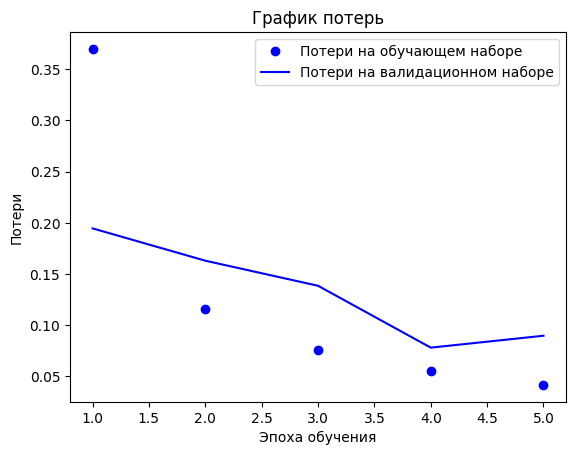

In [ ]:
%matplotlib inline

# Построение линейного графика
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Потери на обучающем наборе')
plt.plot(epochs, val_loss_values, 'b', label='Потери на валидационном наборе')
plt.title('График потерь')
plt.xlabel('Эпоха обучения')
plt.ylabel('Потери')
plt.legend()
plt.show()

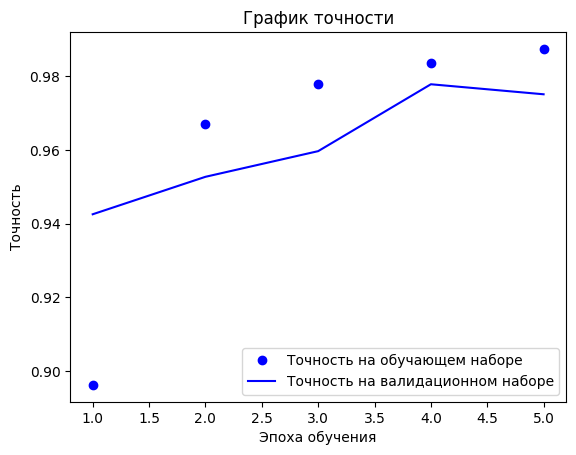

In [ ]:
%matplotlib inline

# Построение линейного графика
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Точность на обучающем наборе')
plt.plot(epochs, val_acc_values, 'b', label='Точность на валидационном наборе')
plt.title('График точности')
plt.xlabel('Эпоха обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

## **Выводы**

На основе имеющихся данных о процессе обучения модели можно сделать несколько выводов:

1. **Улучшение точности**: Точность модели на обучающем наборе данных последовательно увеличивается с каждой эпохой. Это указывает на то, что модель хорошо обучается на предоставленных данных.

2. **Снижение потерь**: Значение функции потерь на обучающем наборе также уменьшается с каждой эпохой, что свидетельствует о том, что модель становится более точной в своих предсказаниях.

3. **Точность на валидационном наборе**: Точность на валидационном наборе данных также последовательно увеличивается к четвертой эпохе, но немного снижается на пятой. Это может указывать на небольшое переобучение, но в целом модель демонстрирует хорошую обобщающую способность.

4. **Потери на валидационном наборе**: Значение функции потерь на валидационном наборе также уменьшается, что подтверждает улучшение качества модели. Однако на пятой эпохе наблюдается небольшое увеличение потерь, что может быть признаком переобучения.

В целом, модель демонстрирует хорошие показатели.